In [175]:


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import numpy as np

from scipy.stats import loguniform
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Lasso
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import RandomizedSearchCV, RepeatedStratifiedKFold, train_test_split

# Import keras libraries
import tensorflow
from tensorflow import keras
from keras import layers
import keras_tuner
from keras_tuner.tuners import Hyperband
import IPython

import warnings
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# import dataset (which we created in Task 1)
# dfPhiladelphiaIncluding0TripsUniqueHours = pd.read_csv("data/exports/dfPhiladelphiaIncluding0TripsUniqueHours.csv.zip")
# dfPhiladelphiaIncluding0TripsUniqueHours.info()

In [176]:
# read in dataset
charging_set_complete = pd.read_csv("data/cleaned_charging_set_new.csv")

In [177]:
# read in dataset
weather_set = pd.read_csv("data/cleaned_weather_set.csv")

In [178]:
# seperate data into site 1 and site 2
charging_set_site1 = charging_set_complete[charging_set_complete["siteID"] == 1]
charging_set_site2 = charging_set_complete[charging_set_complete["siteID"] == 2]

In [179]:
# Create a copy of the DataFrame to avoid the warning
charging_set_site1 = charging_set_site1.copy()

# Convert to datetime
charging_set_site1["connectionTime"] = pd.to_datetime(charging_set_site1["connectionTime"])
charging_set_site1["disconnectTime"] = pd.to_datetime(charging_set_site1["disconnectTime"])

# Sort ascending
charging_set_site1 = charging_set_site1.sort_values(by="connectionTime").reset_index(drop=True)

# Set min and max time
min_time = charging_set_site1["connectionTime"].min().floor("h")
max_time = charging_set_site1["disconnectTime"].max().ceil("h")

# Create DataFrame for every hour
hours_df = pd.DataFrame({"hour": pd.date_range(start=min_time, end=max_time, freq="h")})
hours_df.head()


,hour
0,2018-09-05 11:00:00+00:00
1,2018-09-05 12:00:00+00:00
2,2018-09-05 13:00:00+00:00
3,2018-09-05 14:00:00+00:00
4,2018-09-05 15:00:00+00:00


In [180]:
# Combine date and time columns into single datetime columns
charging_set_site2 = charging_set_site2.copy()

charging_set_site2["connectionTime"] = pd.to_datetime(charging_set_site2["connectionTime"])
charging_set_site2["disconnectTime"] = pd.to_datetime(charging_set_site2["disconnectTime"])
# sort ascending
charging_set_site2 = charging_set_site2.sort_values(by='connectionTime').reset_index(drop=True)
# set min and max time 
min_time = charging_set_site2['connectionTime'].min().floor('h')
max_time = charging_set_site2['disconnectTime'].max().ceil('h')
# create df
hours_df2 = pd.DataFrame({'hour': pd.date_range(start=min_time, end=max_time, freq='h')})
hours_df2.head()


,hour
0,2018-04-25 11:00:00+00:00
1,2018-04-25 12:00:00+00:00
2,2018-04-25 13:00:00+00:00
3,2018-04-25 14:00:00+00:00
4,2018-04-25 15:00:00+00:00


Now we want to create our target variables that we want to predict later. For this we create 2 values:
- connectedCars: the number of active charging sessions for each other
    - utilization: the actual number of minutes that was charged for each hour

The utiliaztion column effectivly sums up the active charging minutes for each hour and divides that by the maximum number of minutes that could be charged. In case of sitze 1 for example that would mean 60x52 = 3120 are the max charging miinutes for this site per hour. If we divide the minutes of active sessions by this value, we get the precise percentage of the charging site utilization.

# CALCULATION FOR SITE 1

In [181]:


# Number of spaces (total available spaces site 1)
total_spaces = 52

# Function to calculate active session minutes for each hour
def calculate_utilization(hour, charging_set_site1, total_spaces):
    start_of_hour = hour
    end_of_hour = hour + pd.Timedelta(hours=1)

    # Filter sessions active during this hour
    active_sessions = charging_set_site1[
        (charging_set_site1['connectionTime'] < end_of_hour) & (charging_set_site1['disconnectTime'] > start_of_hour)
        ]

    # Calculate active minutes for each session
    active_minutes = 0
    for _, session in active_sessions.iterrows():
        session_start = max(session['connectionTime'], start_of_hour)
        session_end = min(session['disconnectTime'], end_of_hour)
        active_minutes += (session_end - session_start).total_seconds() / 60  # Convert to minutes

    # count number of cars
    connected_cars = len(active_sessions)
    # Utilization as a percentage
    possible_minutes = total_spaces * 60  # 60 minutes per hour per space
    utilization = active_minutes / possible_minutes if possible_minutes > 0 else 0
    return utilization, connected_cars


# Compute utilization column
hours_df['utilization'] = hours_df['hour'].apply(
    lambda h: calculate_utilization(h, charging_set_site1, total_spaces)[0]
)

# Compute connectedCars column
hours_df['connectedCars'] = hours_df['hour'].apply(
    lambda h: calculate_utilization(h, charging_set_site1, total_spaces)[1]
)

# Display results
hours_df.head()


,hour,utilization,connectedCars
0,2018-09-05 11:00:00+00:00,0.034498,2
1,2018-09-05 12:00:00+00:00,0.049119,4
2,2018-09-05 13:00:00+00:00,0.139071,10
3,2018-09-05 14:00:00+00:00,0.260994,15
4,2018-09-05 15:00:00+00:00,0.269231,14


# CALCULATION FOR SITE 2

In [182]:
# Number of spaces (total available spaces site 1)
total_spaces = 54

# Function to calculate active session minutes for each hour
def calculate_utilization(hour, charging_set_site2, total_spaces):
    start_of_hour = hour
    end_of_hour = hour + pd.Timedelta(hours=1)

    # Filter sessions active during this hour
    active_sessions = charging_set_site2[
        (charging_set_site2['connectionTime'] < end_of_hour) & (charging_set_site2['disconnectTime'] > start_of_hour)
        ]

    # Calculate active minutes for each session
    active_minutes = 0
    for _, session in active_sessions.iterrows():
        session_start = max(session['connectionTime'], start_of_hour)
        session_end = min(session['disconnectTime'], end_of_hour)
        active_minutes += (session_end - session_start).total_seconds() / 60  # Convert to minutes

    # count number of cars
    connected_cars = len(active_sessions)
    # Utilization as a percentage
    possible_minutes = total_spaces * 60  # 60 minutes per hour per space
    utilization = active_minutes / possible_minutes if possible_minutes > 0 else 0
    return utilization, connected_cars


# Compute utilization column
hours_df2['utilization'] = hours_df2['hour'].apply(
    lambda h: calculate_utilization(h, charging_set_site2, total_spaces)[0]
)

# Compute connectedCars column
hours_df2['connectedCars'] = hours_df2['hour'].apply(
    lambda h: calculate_utilization(h, charging_set_site2, total_spaces)[1]
)

# Display results
hours_df2.head()


,hour,utilization,connectedCars
0,2018-04-25 11:00:00+00:00,0.016029,1
1,2018-04-25 12:00:00+00:00,0.018519,1
2,2018-04-25 13:00:00+00:00,0.015175,3
3,2018-04-25 14:00:00+00:00,0.059378,7
4,2018-04-25 15:00:00+00:00,0.253596,22


# MERGE TARGET VARIABLE AND WEATHER DATASET

In [183]:
# transform column to the same format
hours_df["hour"] = hours_df["hour"].dt.tz_localize(None)
hours_df2["hour"] = hours_df2["hour"].dt.tz_localize(None)

# Convert the "timestamp" column in the weather data to datetime
weather_set["timestamp"] = pd.to_datetime(weather_set["timestamp"])

# Round the weather data timestamps to the nearest hour
weather_set["timestamp"] = weather_set["timestamp"].dt.floor("h")

# Merge the datasets based on the "timestamp" column
merged_data_site1 = pd.merge(hours_df, weather_set, left_on="hour", right_on="timestamp", how="left")
merged_data_site2 = pd.merge(hours_df2, weather_set, left_on="hour", right_on="timestamp", how="left")
# Drop the redundant "timestamp" column from the weather data after merging
merged_data_site1 = merged_data_site1.drop(columns=["timestamp"])
merged_data_site2 = merged_data_site2.drop(columns=["timestamp"])

In [184]:
start_date = "2020-08-02"
end_date = "2020-10-31"

filtered_data = merged_data_site1.loc[
    (merged_data_site1['hour'] >= pd.to_datetime(start_date)) &
    (merged_data_site1['hour'] <= pd.to_datetime(end_date))
    ]
filtered_data2 = merged_data_site2.loc[
    (merged_data_site2['hour'] >= pd.to_datetime(start_date)) &
    (merged_data_site2['hour'] <= pd.to_datetime(end_date))
    ]
print(len(filtered_data),len(filtered_data2))

2300 2300


In [185]:
merged_data_site1 = merged_data_site1.loc[
    ~((merged_data_site1['hour'] >= pd.to_datetime(start_date)) &
      (merged_data_site1['hour'] <= pd.to_datetime(end_date)))
]
merged_data_site2 = merged_data_site2.loc[
    ~((merged_data_site2['hour'] >= pd.to_datetime(start_date)) &
      (merged_data_site2['hour'] <= pd.to_datetime(end_date)))
]

# FEATURE ENGINEERING

CREATE NEW FEATURES FOR SITE 1

In [186]:
# create season column and weekend/weekday column and covvid column
merged_data_site1["hour"] = pd.to_datetime(merged_data_site1["hour"])
# Add covid column
merged_data_site1["covid"] = merged_data_site1["hour"].apply(lambda x: 0 if x < pd.Timestamp("2020-03-01") else 1)

merged_data_site1["weekday"] = merged_data_site1["hour"].apply(lambda x: x.weekday())

# Function to map months to seasons
def get_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    elif month in [9, 10,11]:
        return "Fall"
    return np.nan

# Apply the season mapping
merged_data_site1["Season"] = merged_data_site1["date_month"].apply(get_season)

# Add weekday/weekend column 
merged_data_site1["Weekday/Weekend"] = merged_data_site1["hour"].apply(lambda x: 1 if x.weekday()>=5 else 0)
# Mapping seasons to numeric values
season_mapping = {"Winter": 0, "Spring": 1, "Summer": 2, "Fall": 3}
merged_data_site1["Season"] = merged_data_site1["Season"].map(season_mapping)


# create df column for time of day
def assign_category(hour):
    if hour >= 23 or hour < 6:
        return 0  # Night
    elif 6 <= hour < 12:
        return 1  # Morning
    elif 12 <= hour < 18:
        return 2  # Afternoon
    else:
        return 3  # Evening

# Apply the function to create a new column
merged_data_site1["time_of_day"] = merged_data_site1["hour"].dt.hour.apply(assign_category)

# create  precise hour of day column
merged_data_site1["hour_of_day"] = merged_data_site1["hour"].dt.hour

# Resulting DataFrame
merged_data_site1.head()


,hour,utilization,connectedCars,city,temperature,cloud_cover,cloud_cover_description,pressure,windspeed,precipitation,...,thunder,thunder_in_vicinity,cloudy,smoke,covid,weekday,Season,Weekday/Weekend,time_of_day,hour_of_day
0,2018-09-05 11:00:00,0.034498,2,Burbank,19.0,26.0,Cloudy,984.83,6.0,0.0,...,0.0,0.0,1.0,0.0,0,2,3.0,0,1,11
1,2018-09-05 12:00:00,0.049119,4,Burbank,19.0,26.0,Cloudy,985.49,6.0,0.0,...,0.0,0.0,1.0,0.0,0,2,3.0,0,2,12
2,2018-09-05 13:00:00,0.139071,10,Burbank,19.0,28.0,Mostly Cloudy,986.15,7.0,0.0,...,0.0,0.0,1.0,0.0,0,2,3.0,0,2,13
3,2018-09-05 13:00:00,0.139071,10,Burbank,19.0,28.0,Mostly Cloudy,986.15,7.0,0.0,...,0.0,0.0,1.0,0.0,0,2,3.0,0,2,13
4,2018-09-05 14:00:00,0.260994,15,Burbank,19.0,28.0,Mostly Cloudy,986.81,0.0,0.0,...,0.0,0.0,1.0,0.0,0,2,3.0,0,2,14


In [187]:
# drop NaN values
merged_data_site1 = merged_data_site1.dropna()
merged_data_site2 = merged_data_site2.dropna()

In [188]:
start_date = "2020-08-02"
end_date = "2020-10-31"

filtered_data = merged_data_site1.loc[
    (merged_data_site1['hour'] >= pd.to_datetime(start_date)) &
    (merged_data_site1['hour'] <= pd.to_datetime(end_date))
    ]
filtered_data2 = merged_data_site2.loc[
    (merged_data_site2['hour'] >= pd.to_datetime(start_date)) &
    (merged_data_site2['hour'] <= pd.to_datetime(end_date))
    ]
# print(len(filtered_data),len(filtered_data2))

In [189]:
zero_connected_cars_count = filtered_data[filtered_data['connectedCars'] == 0].shape[0]
zero_connected_cars_count2 = filtered_data2[filtered_data2['connectedCars'] == 0].shape[0]
print(zero_connected_cars_count,zero_connected_cars_count2)

0 0


## REMOVE DATA GAP FROM AUGUST 2020 UNTIL OKTOBER 2020

In [190]:
merged_data_site1 = merged_data_site1.loc[
    ~((merged_data_site1['hour'] >= pd.to_datetime(start_date)) &
      (merged_data_site1['hour'] <= pd.to_datetime(end_date)))
]
merged_data_site2 = merged_data_site2.loc[
    ~((merged_data_site2['hour'] >= pd.to_datetime(start_date)) &
      (merged_data_site2['hour'] <= pd.to_datetime(end_date)))
]

# CREATE NEW FEATURES FOR SITE 1

In [191]:
# create season column and weekend/weekday column and covvid column
merged_data_site1["hour"] = pd.to_datetime(merged_data_site1["hour"])
# Add covid column
merged_data_site1["covid"] = merged_data_site1["hour"].apply(lambda x: 0 if x < pd.Timestamp("2020-03-01") else 1)

merged_data_site1["weekday"] = merged_data_site1["hour"].apply(lambda x: x.weekday())

# Function to map months to seasons
def get_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    elif month in [9, 10,11]:
        return "Fall"
    return np.nan

# Apply the season mapping
merged_data_site1["Season"] = merged_data_site1["date_month"].apply(get_season)

# Add weekday/weekend column 
merged_data_site1["Weekday/Weekend"] = merged_data_site1["hour"].apply(lambda x: 1 if x.weekday()>=5 else 0)
# Mapping seasons to numeric values
season_mapping = {"Winter": 0, "Spring": 1, "Summer": 2, "Fall": 3}
merged_data_site1["Season"] = merged_data_site1["Season"].map(season_mapping)


# create df column for time of day
def assign_category(hour):
    if hour >= 23 or hour < 6:
        return 0  # Night
    elif 6 <= hour < 12:
        return 1  # Morning
    elif 12 <= hour < 18:
        return 2  # Afternoon
    else:
        return 3  # Evening

# Apply the function to create a new column
merged_data_site1["time_of_day"] = merged_data_site1["hour"].dt.hour.apply(assign_category)

# create  precise hour of day column
merged_data_site1["hour_of_day"] = merged_data_site1["hour"].dt.hour

# Resulting DataFrame
merged_data_site1.head()


,hour,utilization,connectedCars,city,temperature,cloud_cover,cloud_cover_description,pressure,windspeed,precipitation,...,thunder,thunder_in_vicinity,cloudy,smoke,covid,weekday,Season,Weekday/Weekend,time_of_day,hour_of_day
0,2018-09-05 11:00:00,0.034498,2,Burbank,19.0,26.0,Cloudy,984.83,6.0,0.0,...,0.0,0.0,1.0,0.0,0,2,3,0,1,11
1,2018-09-05 12:00:00,0.049119,4,Burbank,19.0,26.0,Cloudy,985.49,6.0,0.0,...,0.0,0.0,1.0,0.0,0,2,3,0,2,12
2,2018-09-05 13:00:00,0.139071,10,Burbank,19.0,28.0,Mostly Cloudy,986.15,7.0,0.0,...,0.0,0.0,1.0,0.0,0,2,3,0,2,13
3,2018-09-05 13:00:00,0.139071,10,Burbank,19.0,28.0,Mostly Cloudy,986.15,7.0,0.0,...,0.0,0.0,1.0,0.0,0,2,3,0,2,13
4,2018-09-05 14:00:00,0.260994,15,Burbank,19.0,28.0,Mostly Cloudy,986.81,0.0,0.0,...,0.0,0.0,1.0,0.0,0,2,3,0,2,14


# CREATE NEW FEATURES FOR SITE 2

In [192]:
# create season column and weekend/weekday column and covvid column
merged_data_site2["hour"] = pd.to_datetime(merged_data_site2["hour"])
# Add covid column
merged_data_site2["covid"] = merged_data_site2["hour"].apply(lambda x: 0 if x < pd.Timestamp("2020-03-01") else 1)

merged_data_site2["weekday"] = merged_data_site2["hour"].apply(lambda x: x.weekday())

# Function to map months to seasons
def get_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    elif month in [9, 10,11]:
        return "Fall"
    return np.nan

# Apply the season mapping
merged_data_site2["Season"] = merged_data_site2["date_month"].apply(get_season)

# Add weekday/weekend column 
merged_data_site2["Weekday/Weekend"] = merged_data_site2["hour"].apply(lambda x: 1 if x.weekday()>=5 else 0)
# Mapping seasons to numeric values
season_mapping = {"Winter": 0, "Spring": 1, "Summer": 2, "Fall": 3}
merged_data_site2["Season"] = merged_data_site2["Season"].map(season_mapping)


# create df column for time of day
def assign_category(hour):
    if hour >= 23 or hour < 6:
        return 0  # Night
    elif 6 <= hour < 12:
        return 1  # Morning
    elif 12 <= hour < 18:
        return 2  # Afternoon
    else:
        return 3  # Evening

# Apply the function to create a new column
merged_data_site2["time_of_day"] = merged_data_site2["hour"].dt.hour.apply(assign_category)

# create  precise hour of day column
merged_data_site2["hour_of_day"] = merged_data_site2["hour"].dt.hour
# Resulting DataFrame
merged_data_site2.head()


,hour,utilization,connectedCars,city,temperature,cloud_cover,cloud_cover_description,pressure,windspeed,precipitation,...,thunder,thunder_in_vicinity,cloudy,smoke,covid,weekday,Season,Weekday/Weekend,time_of_day,hour_of_day
0,2018-04-25 11:00:00,0.016029,1,Burbank,12.0,27.0,Mostly Cloudy,989.11,6.0,0.0,...,0.0,0.0,1.0,0.0,0,2,1,0,1,11
1,2018-04-25 12:00:00,0.018519,1,Burbank,12.0,27.0,Mostly Cloudy,989.11,7.0,0.0,...,0.0,0.0,1.0,0.0,0,2,1,0,2,12
2,2018-04-25 12:00:00,0.018519,1,Burbank,12.0,28.0,Mostly Cloudy,989.11,9.0,0.0,...,0.0,0.0,1.0,0.0,0,2,1,0,2,12
3,2018-04-25 13:00:00,0.015175,3,Burbank,12.0,20.0,Fog,989.44,9.0,0.0,...,0.0,0.0,0.0,0.0,0,2,1,0,2,13
4,2018-04-25 13:00:00,0.015175,3,Burbank,12.0,20.0,Fog,989.44,7.0,0.0,...,0.0,0.0,0.0,0.0,0,2,1,0,2,13


## REMOVE CITY & CLOUD_COVER_DESCRIPTION FROM DATASET

In [193]:
print("merged data site 1:", merged_data_site1.columns)
print("merged data site 2:", merged_data_site2.columns)

merged data site 1: Index(['hour', 'utilization', 'connectedCars', 'city', 'temperature',
       'cloud_cover', 'cloud_cover_description', 'pressure', 'windspeed',
       'precipitation', 'felt_temperature', 'temperature_difference',
       'date_year', 'date_month', 'date_day', 'time', 'mostly', 'heavy', 'fog',
       'windy', 'blowing_dust', 'fair', 'haze', 'partly', 'rain',
       'light_rain_thunder', 'light', 't-storm', 'thunder',
       'thunder_in_vicinity', 'cloudy', 'smoke', 'covid', 'weekday', 'Season',
       'Weekday/Weekend', 'time_of_day', 'hour_of_day'],
      dtype='object')
merged data site 2: Index(['hour', 'utilization', 'connectedCars', 'city', 'temperature',
       'cloud_cover', 'cloud_cover_description', 'pressure', 'windspeed',
       'precipitation', 'felt_temperature', 'temperature_difference',
       'date_year', 'date_month', 'date_day', 'time', 'mostly', 'heavy', 'fog',
       'windy', 'blowing_dust', 'fair', 'haze', 'partly', 'rain',
       'light_rain_thu

In [194]:
merged_data_site1.drop(columns=['city', 'cloud_cover_description', 'hour', 'time'], axis=1, inplace=True)
merged_data_site2.drop(columns=['city', 'cloud_cover_description', 'hour', 'time'], axis=1, inplace=True)

# FEATURE SELECTION FOR SITE 1

In [195]:

# Compute correlation matrix
correlation_matrix = merged_data_site1.corr()


# Correlation with target feature
target_correlation = correlation_matrix['connectedCars'].sort_values(ascending=False)
print("Correlation with connectedCars:")
print(target_correlation)


Correlation with connectedCars:
connectedCars             1.000000
utilization               0.990629
hour_of_day               0.437452
time_of_day               0.381940
felt_temperature          0.228024
temperature               0.226568
windspeed                 0.148433
haze                      0.067648
temperature_difference    0.036816
precipitation             0.032400
t-storm                   0.032212
cloud_cover               0.026539
partly                    0.024899
heavy                     0.022309
thunder                   0.017571
rain                      0.012029
pressure                  0.010279
windy                     0.010257
light                     0.007884
Season                    0.007207
fair                     -0.000660
mostly                   -0.005568
fog                      -0.008701
date_day                 -0.016249
cloudy                   -0.023833
smoke                    -0.026687
date_month               -0.040253
date_year              

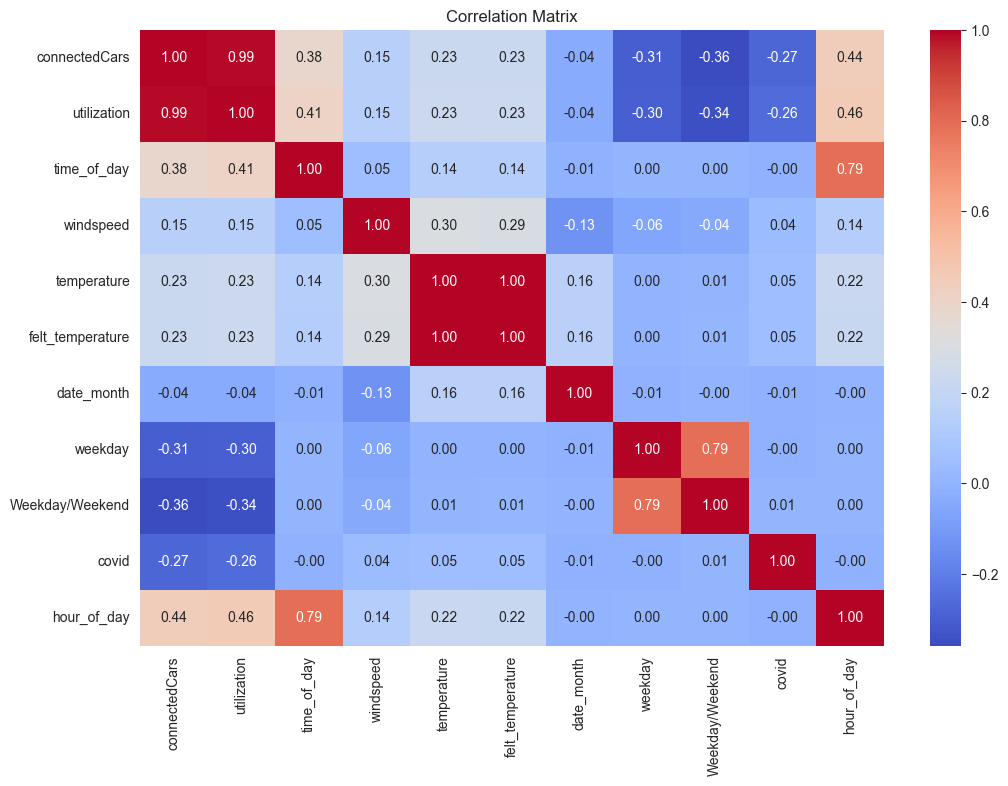

In [196]:
# compute correlation and display correlation for newly selected features
predictionDF_site1 = merged_data_site1[["connectedCars", "utilization","time_of_day","windspeed","temperature","felt_temperature","date_month","weekday","Weekday/Weekend","covid","hour_of_day"]]
correlation_matrix = predictionDF_site1.corr()
# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

# FEATURE SELECTION SITE 2

In [197]:

# Compute correlation matrix
correlation_matrix = merged_data_site2.corr()


# Correlation with target feature
target_correlation = correlation_matrix['connectedCars'].sort_values(ascending=False)
print("Correlation with connectedCars:")
print(target_correlation)

Correlation with connectedCars:
connectedCars             1.000000
utilization               0.989156
felt_temperature          0.408933
temperature               0.405166
hour_of_day               0.305628
time_of_day               0.236789
windspeed                 0.231861
Season                    0.151461
temperature_difference    0.115575
cloud_cover               0.084475
fair                      0.052255
partly                    0.035498
date_month                0.032912
haze                      0.029883
thunder                   0.021855
t-storm                   0.016176
smoke                     0.009457
windy                    -0.002048
date_day                 -0.003853
heavy                    -0.008798
precipitation            -0.011147
light                    -0.026306
mostly                   -0.027441
rain                     -0.034919
fog                      -0.035822
cloudy                   -0.043821
pressure                 -0.106504
weekday                

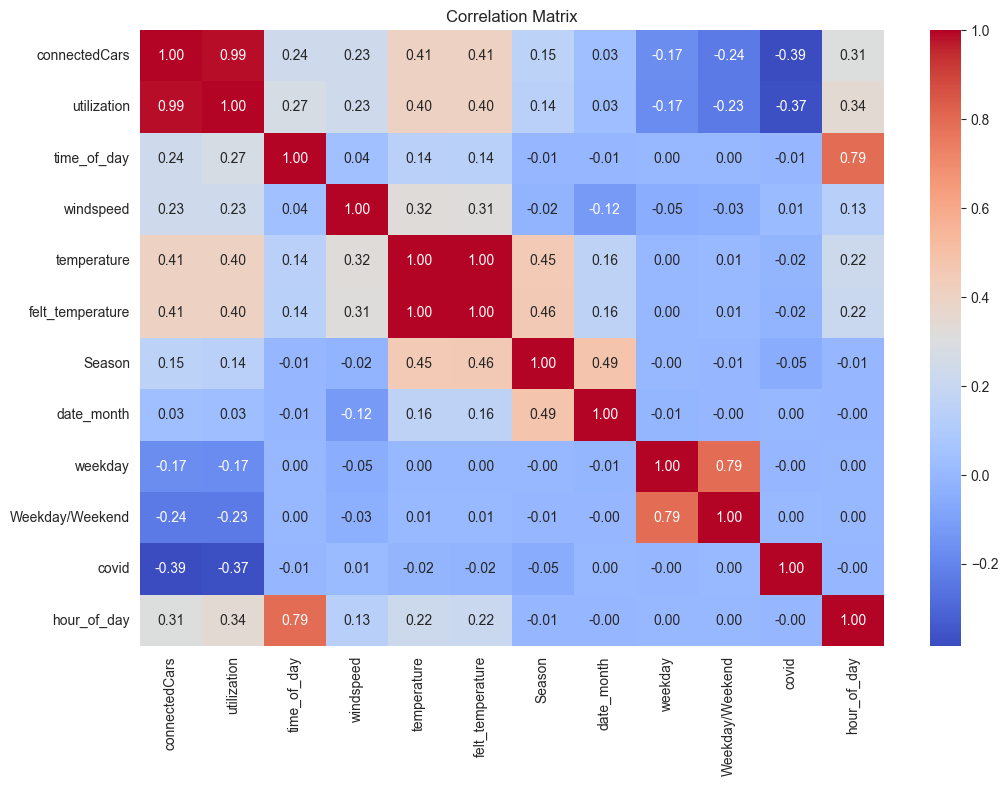

In [198]:
# compute correlation and display correlation for newly selected features
predictionDF_site2 = merged_data_site2[["connectedCars", "utilization","time_of_day","windspeed","temperature","felt_temperature","Season","date_month","weekday","Weekday/Weekend","covid","hour_of_day"]]
correlation_matrix = predictionDF_site2.corr()
# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

# ------------------------------------------------------------------------------------


# ---------------------------------HOT STUFF---------------------------------

# ------------------------------------------------------------------------------------

## NEURAL NETWORK: PREDICTION connectedCars SITE 1

In [199]:
X_s1 = predictionDF_site1.copy()
X_s1 = X_s1.drop(["connectedCars","utilization","temperature","time_of_day"], axis = 1)
y_s1 = predictionDF_site1[["connectedCars"]]

In [200]:
X_s1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20351 entries, 0 to 22813
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   windspeed         20351 non-null  float64
 1   felt_temperature  20351 non-null  float64
 2   date_month        20351 non-null  float64
 3   weekday           20351 non-null  int64  
 4   Weekday/Weekend   20351 non-null  int64  
 5   covid             20351 non-null  int64  
 6   hour_of_day       20351 non-null  int32  
dtypes: float64(3), int32(1), int64(3)
memory usage: 1.2 MB


In [201]:
# Split data into train and test sets
X_s1_train, X_s1_test, y_s1_train, y_s1_test = train_test_split(X_s1, y_s1, test_size=0.3, random_state=42)
X_s1_train, X_s1_val, y_s1_train, y_s1_val = train_test_split(X_s1_train, y_s1_train, test_size=(0.2/0.7),random_state = 42)

                                                  # Standardize the feature values
scaler = StandardScaler()
X_s1_train = scaler.fit_transform(X_s1_train)
X_s1_val = scaler.fit_transform(X_s1_val)
X_s1_test = scaler.transform(X_s1_test)

In [202]:
def build_model_nn_s1(hp):
    # Input Layer
    inputs = keras.Input(shape=(7,)) # shapesize dependent of input feature count

    # Hidden Layers
    ## First Hidden Layer
    dense = layers.Dense(units=hp.Int('hidden_layer_1_units', min_value=32, max_value=256, step=32), activation='relu')
    x = dense(inputs)

    ## Possible additional Hidden Layers
    for i in range(hp.Int('total_added_hidden_layers', 0, 10)):
        x = layers.Dense(units=hp.Int(f'hidden_layers_{i+2}_units', min_value=32, max_value=256, step=32), activation='relu')(x)

    # Output Layer
    output = layers.Dense(1, activation='relu')(x)

    # Instantiate the model
    model_ann = keras.Model(inputs, output, name='connectedCars_NN_site1')

    # Compile the model
    model_ann.compile(optimizer='Adam', loss='mean_squared_error')

    return model_ann

# HYPERPARAMETER TUNING SITE 1

In [203]:
tuner_nn_s1 = Hyperband(
    build_model_nn_s1,
    objective = 'val_loss',
    max_epochs = 20,
    factor = 3,
    executions_per_trial = 1,
    project_name = 'kerastuner_LOG',
    overwrite = True # deletes old LOG's
)

In [204]:
# display search space
tuner_nn_s1.search_space_summary()

Search space summary
Default search space size: 2
hidden_layer_1_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
total_added_hidden_layers (Int)
{'default': None, 'conditions': [], 'min_value': 0, 'max_value': 10, 'step': 1, 'sampling': 'linear'}


In [205]:
# define callback to clear training outputs at end of every training step
class ClearTrainingOutput(keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait = True)

# RUN HYPERPARAMETER SEARCH

In [206]:
tuner_nn_s1.search(
    X_s1_train,
    y_s1_train,
    validation_data=(X_s1_val,y_s1_val),
    callbacks = [ClearTrainingOutput()]
)

Trial 30 Complete [00h 00m 38s]
val_loss: 51.349456787109375

Best val_loss So Far: 48.357398986816406
Total elapsed time: 00h 08m 01s


In [207]:
# display best models, their hyperparameters and the resulting metrics
tuner_nn_s1.results_summary()

Results summary
Results in ./kerastuner_LOG
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 0026 summary
Hyperparameters:
hidden_layer_1_units: 256
total_added_hidden_layers: 8
hidden_layers_2_units: 224
hidden_layers_3_units: 32
hidden_layers_4_units: 256
hidden_layers_5_units: 256
hidden_layers_6_units: 224
hidden_layers_7_units: 256
hidden_layers_8_units: 32
hidden_layers_9_units: 256
hidden_layers_10_units: 64
hidden_layers_11_units: 224
tuner/epochs: 20
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 48.357398986816406

Trial 0024 summary
Hyperparameters:
hidden_layer_1_units: 128
total_added_hidden_layers: 5
hidden_layers_2_units: 96
hidden_layers_3_units: 224
hidden_layers_4_units: 192
hidden_layers_5_units: 64
hidden_layers_6_units: 160
hidden_layers_7_units: 160
hidden_layers_8_units: 64
hidden_layers_9_units: 128
hidden_layers_10_units: 192
hidden_layers_11_units: 64
tuner/epochs: 20
tuner/initial_epoch: 7
tuner/bracket: 1
tuner/round: 

In [208]:
nn_best_hps_site1 = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
The hyperparameter search is complete. 
The optimal number of units in the first hidden layer is {nn_best_hps_site1.get('hidden_layer_1_units')} 
and the total number of hidden layers is {nn_best_hps_site1.get('total_added_hidden_layers')+1}.
""")


The hyperparameter search is complete. 
The optimal number of units in the first hidden layer is 160 
and the total number of hidden layers is 7.


In [209]:
# get best model
nn_model_site1 = tuner_nn_s1.get_best_models(num_models=1)[0]

/Users/anthonyge/Desktop/UNI/_MASTER/semester_1/Analytics_&_Applications/GinyuForce/venv/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 42 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [210]:
nn_model_site1.summary()

Model: "connectedCars_NN_site1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 7)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 224)            │        57,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         7,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │         8,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 224)            │        57,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │        57,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │         8,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 273,153 (1.04 MB)

 Trainable params: 273,153 (1.04 MB)

 Non-trainable params: 0 (0.00 B)

In [211]:
callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=100,
    restore_best_weights=True
)

In [212]:
nn_model_site1.fit(X_s1_train, y_s1_train, epochs=1000, validation_data=(X_s1_val,y_s1_val), callbacks=[callback])


Epoch 1/1000
318/318 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 50.6217 - val_loss: 50.8152
Epoch 2/1000
318/318 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 43.8557 - val_loss: 59.3137
Epoch 3/1000
318/318 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 44.4910 - val_loss: 53.7349
Epoch 4/1000
318/318 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 48.9085 - val_loss: 53.2770
Epoch 5/1000
318/318 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 40.4284 - val_loss: 50.4442
Epoch 6/1000
318/318 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 42.8156 - val_loss: 54.6420
Epoch 7/1000
318/318 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 48.5419 - val_loss: 52.1983
Epoch 8/1000
318/318 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 46.0318 - val_loss: 54.9998
Epoch 9/1000
318/318 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 44.7567 - val_loss: 50.0042
Epoch 10/1000
318/318 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 41.8231 - val_loss: 57.7826
Epoch 11/1000
318/318 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 44.0902 - val_loss: 51.2654
Epoch 12

In [213]:
nn_pred_site1 = nn_model_site1.predict(X_s1_test)

# Calculate MAE, RMSE and r2
nn_mae_s1 = mean_absolute_error(y_s1_test,nn_pred_site1)
nn_rmse_s1 = mean_squared_error(y_s1_test,nn_pred_site1)**0.5
nn_r2_s1 = r2_score(y_s1_test, nn_pred_site1)

print("MAE:", nn_mae_s1)
print("RMSE:", nn_rmse_s1)
print("R2:", nn_r2_s1)
print("Accuracy:", round((1-(nn_mae_s1/predictionDF_site1["connectedCars"].mean()))*100,2), "%")


191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
MAE: 3.358940362930298
RMSE: 7.207355969564809
R2: 0.8538559675216675
Accuracy: 72.09 %


# NEURAL NETWORK: PREDICTION connectedCars SITE 2

In [214]:
X_s2 = predictionDF_site2.copy()
X_s2 = X_s2.drop(["connectedCars","utilization","temperature","time_of_day"], axis = 1)
y_s2 = predictionDF_site2[["connectedCars"]]

In [215]:
X_s2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23792 entries, 0 to 26295
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   windspeed         23792 non-null  float64
 1   felt_temperature  23792 non-null  float64
 2   Season            23792 non-null  int64  
 3   date_month        23792 non-null  float64
 4   weekday           23792 non-null  int64  
 5   Weekday/Weekend   23792 non-null  int64  
 6   covid             23792 non-null  int64  
 7   hour_of_day       23792 non-null  int32  
dtypes: float64(3), int32(1), int64(4)
memory usage: 1.5 MB


In [216]:
X_s2.head()

,windspeed,felt_temperature,Season,date_month,weekday,Weekday/Weekend,covid,hour_of_day
0,6.0,12.0,1,4.0,2,0,0,11
1,7.0,12.0,1,4.0,2,0,0,12
2,9.0,12.0,1,4.0,2,0,0,12
3,9.0,12.0,1,4.0,2,0,0,13
4,7.0,12.0,1,4.0,2,0,0,13


In [217]:
X_s1.head()

,windspeed,felt_temperature,date_month,weekday,Weekday/Weekend,covid,hour_of_day
0,6.0,19.0,9.0,2,0,0,11
1,6.0,19.0,9.0,2,0,0,12
2,7.0,19.0,9.0,2,0,0,13
3,7.0,19.0,9.0,2,0,0,13
4,0.0,19.0,9.0,2,0,0,14


In [218]:
# Split data into train and test sets
X_s2_train, X_s2_test, y_s2_train, y_s2_test = train_test_split(X_s2, y_s2, test_size=0.3, random_state=42)
X_s2_train, X_s2_val, y_s2_train, y_s2_val = train_test_split(X_s2_train, y_s2_train, test_size=(0.2/0.7),random_state = 42)

# Standardize the feature values
scaler = StandardScaler()
X_s2_train = scaler.fit_transform(X_s2_train)
X_s2_val = scaler.fit_transform(X_s2_val)
X_s2_test = scaler.transform(X_s2_test)

In [219]:
def build_model_nn_s2(hp):
    # Input Layer
    # season is in here, but not in site 1 df
    inputs = keras.Input(shape=(8,)) # shapesize dependent of input feature count

    # Hidden Layers
    ## First Hidden Layer
    dense = layers.Dense(units=hp.Int('hidden_layer_1_units', min_value=32, max_value=256, step=32), activation='relu')
    x = dense(inputs)

    ## Possible additional Hidden Layers
    for i in range(hp.Int('total_added_hidden_layers', 0, 10)):
        x = layers.Dense(units=hp.Int(f'hidden_layers_{i+2}_units', min_value=32, max_value=256, step=32), activation='relu')(x)

    # Output Layer
    output = layers.Dense(1, activation='relu')(x)

    # Instantiate the model
    model_ann = keras.Model(inputs, output, name='connectedCars_NN_site1')

    # Compile the model
    model_ann.compile(optimizer='Adam', loss='mean_squared_error')

    return model_ann

# HYPERPARAMETER TUNING SITE 2

In [220]:
tuner_nn_s2 = Hyperband(
    build_model_nn_s2,
    objective = 'val_loss',
    max_epochs = 20,
    factor = 3,
    executions_per_trial = 1,
    project_name = 'kerastuner_LOG_nn_site2',
    overwrite = True # deletes old LOG's
)

In [221]:
tuner_nn_s2.search_space_summary()

Search space summary
Default search space size: 2
hidden_layer_1_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
total_added_hidden_layers (Int)
{'default': None, 'conditions': [], 'min_value': 0, 'max_value': 10, 'step': 1, 'sampling': 'linear'}


# RUN HYPERPARAMETER SEARCH SITE 2

In [222]:
tuner_nn_s2.search(
    X_s2_train,
    y_s2_train,
    validation_data=(X_s2_val,y_s2_val),
    callbacks = [ClearTrainingOutput()]
)

Trial 30 Complete [00h 00m 37s]
val_loss: 32.66353988647461

Best val_loss So Far: 31.52553367614746
Total elapsed time: 00h 41m 20s


In [223]:
# display best models, their hyperparameters and the resulting metrics
tuner_nn_s2.results_summary()

Results summary
Results in ./kerastuner_LOG_nn_site2
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 0016 summary
Hyperparameters:
hidden_layer_1_units: 128
total_added_hidden_layers: 3
hidden_layers_2_units: 32
hidden_layers_3_units: 192
hidden_layers_4_units: 160
hidden_layers_5_units: 64
hidden_layers_6_units: 64
hidden_layers_7_units: 160
hidden_layers_8_units: 256
hidden_layers_9_units: 160
hidden_layers_10_units: 192
tuner/epochs: 20
tuner/initial_epoch: 7
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0014
hidden_layers_11_units: 192
Score: 31.52553367614746

Trial 0024 summary
Hyperparameters:
hidden_layer_1_units: 224
total_added_hidden_layers: 8
hidden_layers_2_units: 256
hidden_layers_3_units: 32
hidden_layers_4_units: 160
hidden_layers_5_units: 32
hidden_layers_6_units: 160
hidden_layers_7_units: 256
hidden_layers_8_units: 256
hidden_layers_9_units: 192
hidden_layers_10_units: 96
hidden_layers_11_units: 64
tuner/epochs: 20
tuner/initial_epoch: 7
t

In [224]:
nn_best_hps_site2 = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
The hyperparameter search is complete. 
The optimal number of units in the first hidden layer is {nn_best_hps_site2.get('hidden_layer_1_units')} 
and the total number of hidden layers is {nn_best_hps_site2.get('total_added_hidden_layers')+1}.
""")


The hyperparameter search is complete. 
The optimal number of units in the first hidden layer is 160 
and the total number of hidden layers is 7.


In [225]:
# get best model
nn_model_site2 = tuner_nn_s2.get_best_models(num_models=1)[0]

/Users/anthonyge/Desktop/UNI/_MASTER/semester_1/Analytics_&_Applications/GinyuForce/venv/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [226]:
nn_model_site2.summary()

Model: "connectedCars_NN_site1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 192)            │         6,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 160)            │        30,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,657 (166.63 KB)

 Trainable params: 42,657 (166.63 KB)

 Non-trainable params: 0 (0.00 B)

In [227]:
callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=100,
    restore_best_weights=True
)

In [228]:
nn_model_site2.fit(X_s2_train, y_s2_train, epochs=1000, validation_data=(X_s2_val,y_s2_val), callbacks=[callback])

Epoch 1/1000
372/372 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 27.2750 - val_loss: 32.4701
Epoch 2/1000
372/372 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 27.3168 - val_loss: 33.0509
Epoch 3/1000
372/372 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 27.3317 - val_loss: 35.1598
Epoch 4/1000
372/372 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 26.2418 - val_loss: 31.8511
Epoch 5/1000
372/372 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 26.2913 - val_loss: 34.0545
Epoch 6/1000
372/372 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 26.3341 - val_loss: 34.0060
Epoch 7/1000
372/372 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 26.5011 - val_loss: 31.7076
Epoch 8/1000
372/372 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 26.3869 - val_loss: 35.0189
Epoch 9/1000
372/372 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 25.4619 - val_loss: 31.4625
Epoch 10/1000
372/372 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 25.7851 - val_loss: 35.4775
Epoch 11/1000
372/372 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 25.9324 - val_loss: 32.8828
Epoch 12

In [229]:
nn_pred_site2 = nn_model_site2.predict(X_s2_test)

# Calculate MAE, RMSE and r2
nn_mae_s2 = mean_absolute_error(y_s2_test,nn_pred_site2)
nn_rmse_s2 = mean_squared_error(y_s2_test,nn_pred_site2)**0.5
nn_r2_s2 = r2_score(y_s2_test, nn_pred_site2)
mean_site1_connectedCars = predictionDF_site1["connectedCars"].mean()
mean_site2_connectedCars = predictionDF_site2["connectedCars"].mean()

print("MAE:", nn_mae_s2)
print("RMSE:", nn_rmse_s2)
print("R2:", nn_r2_s2)
print("Accuracy:", round((1-(nn_mae_s2/predictionDF_site2["connectedCars"].mean()))*100,2), "%")
print("average hourly connectedCars site 1:", mean_site1_connectedCars)
print("average hourly connectedCars site 2:", mean_site2_connectedCars)

224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
MAE: 3.2957139015197754
RMSE: 5.297323652413355
R2: 0.788433313369751
Accuracy: 62.22 %
average hourly connectedCars site 1: 12.034740307601592
average hourly connectedCars site 2: 8.724066913248151
